Lendo resultados de: ../data/results
Métricas selecionadas: ['execution_time', 'memory_used_mb', 'initial_memory_mb', 'final_memory_mb']

==== Resumo por linguagem e métrica (topo) ====
language            metric  n         mean       median       std          min          max      ci95
  python    execution_time  6 2.131024e+00 1.030615e+00  2.673998 1.629305e-02 6.652991e+00  2.139644
    java    execution_time  6 4.801700e-02 3.705700e-02  0.053557 6.333000e-03 1.508130e-01  0.042855
    rust    execution_time  6 2.659588e-02 8.504244e-03  0.045902 1.393540e-04 1.186322e-01  0.036729
      go    execution_time  6 2.608045e-02 1.062968e-02  0.042846 3.131660e-04 1.116895e-01  0.034284
    rust   final_memory_mb  6 4.957010e+06 4.957004e+06 14.696938 4.957004e+06 4.957040e+06 11.760000
  python   final_memory_mb  6 1.352409e+01 1.348438e+01  0.261239 1.325391e+01 1.383594e+01  0.209035
    java   final_memory_mb  6 1.463727e+00 1.396301e+00  0.178746 1.370277e+00 1.826881e+00  0.14302

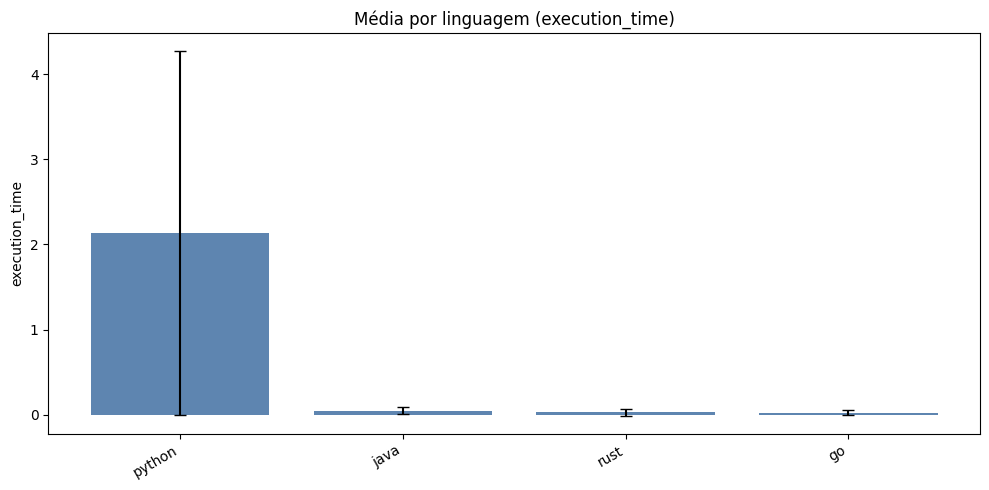

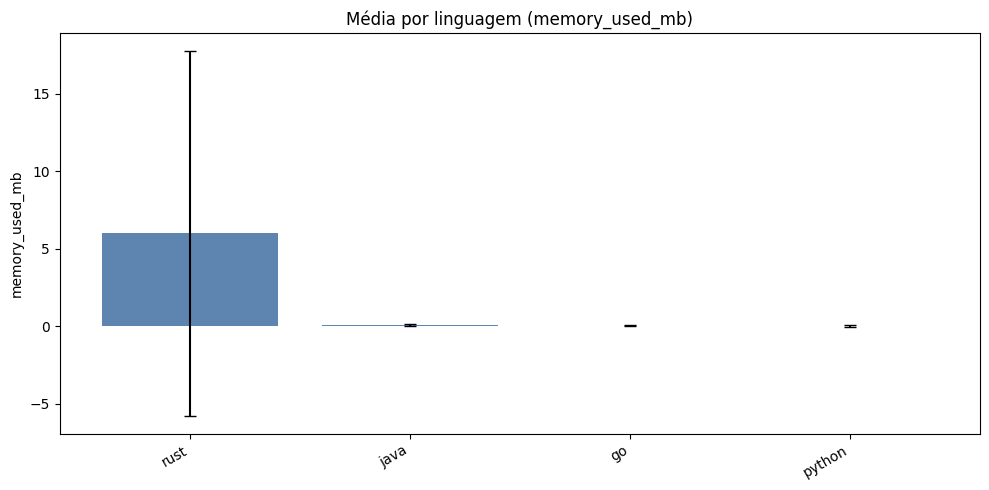

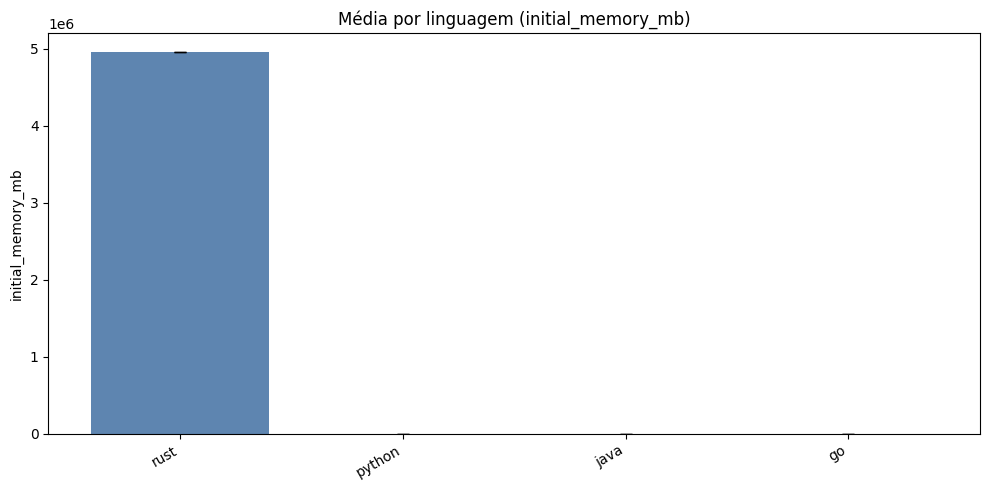

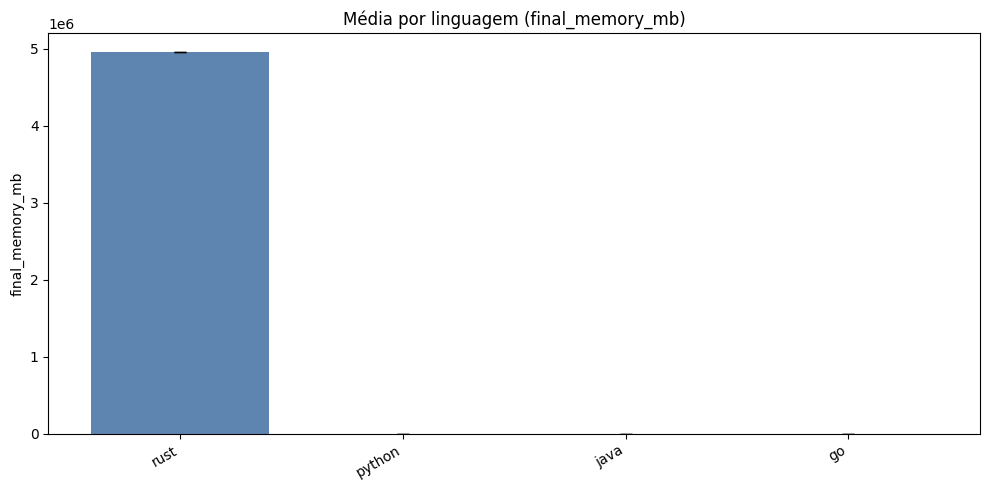

/tmp/ipykernel_53903/1415916680.py:243: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showfliers=False)


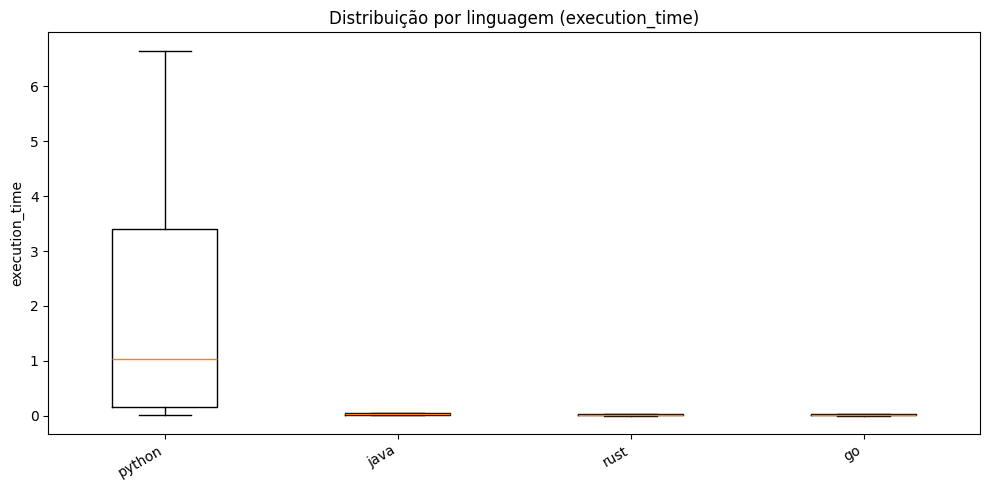


Figuras salvas:
- ./figures/language_mean_execution_time.png
- ./figures/language_mean_memory_used_mb.png
- ./figures/language_mean_initial_memory_mb.png
- ./figures/language_mean_final_memory_mb.png
- ./figures/language_box_execution_time.png


In [15]:
import os
import re
import json
import warnings
from typing import List, Optional, Tuple, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)

try:
    ROOT_DIR  # type: ignore # noqa: F821
except NameError:
    ROOT_DIR = "../data/results"

try:
    OUTPUT_DIR  # type: ignore # noqa: F821
except NameError:
    OUTPUT_DIR = "./figures"

try:
    METRIC_PRIORITY  # type: ignore # noqa: F821
except NameError:
    METRIC_PRIORITY = [
        "accuracy", "acc", "f1", "f1_score", "precision", "recall",
        "bleu", "rouge", "mcc", "rmse", "mae", "mape", "latency", "throughput",
        "pass@1", "pass@k", "exact_match", "loss", "error_rate", "time", "duration_ms"
    ]


def _infer_language_from_path(path: str) -> Optional[str]:
    candidates = {
        "python": ["python", "py"],
        "java": ["java"],
        "go": ["go", "golang"],
        "rust": ["rust", "rs"],
    }

    base = os.path.basename(path).lower()
    parent = os.path.basename(os.path.dirname(path)).lower()

    tokens = re.split(r"[^a-z0-9\+]+", base) + re.split(r"[^a-z0-9\+]+", parent)

    for lang, keys in candidates.items():
        for k in keys:
            if k in tokens or k in base or k in parent:
                return lang

    top_parent = os.path.basename(os.path.dirname(path)).lower()
    if top_parent and top_parent not in {"results", "data", "output", "outputs"}:
        return top_parent

    return None


def _read_any(path: str) -> Optional[pd.DataFrame]:
    ext = os.path.splitext(path)[1].lower()
    try:
        if ext in {".csv"}:
            return pd.read_csv(path)
        if ext in {".tsv"}:
            return pd.read_csv(path, sep="\t")
        if ext in {".parquet"}:
            return pd.read_parquet(path)
        if ext in {".json"}:
            # tenta json lines
            try:
                return pd.read_json(path, lines=True)
            except ValueError:
                # JSON normal (objeto ou lista)
                with open(path, "r", encoding="utf-8") as f:
                    data = json.load(f)
                if isinstance(data, list):
                    return pd.json_normalize(data)
                if isinstance(data, dict):
                    return pd.json_normalize(data)
                return None
    except Exception as e:
        print(f"Aviso: não foi possível ler '{path}': {e}")
        return None
    return None


def load_results(root_dir: str) -> pd.DataFrame:
    if not os.path.isdir(root_dir):
        raise FileNotFoundError(f"Diretório não encontrado: {root_dir}")

    frames: List[pd.DataFrame] = []
    supported_ext = {".csv", ".tsv", ".json", ".parquet"}

    for dirpath, _, filenames in os.walk(root_dir):
        for fname in filenames:
            ext = os.path.splitext(fname)[1].lower()
            if ext not in supported_ext:
                continue
            fpath = os.path.join(dirpath, fname)
            df = _read_any(fpath)
            if df is None or df.empty:
                continue
            df = df.copy()
            lang = _infer_language_from_path(fpath) or "unknown"

            if "data_size" in df.columns:
                df = df.drop(columns=["data_size"])

            df["language"] = lang
            df["source_file"] = os.path.relpath(fpath, root_dir)
            frames.append(df)

    if not frames:
        raise RuntimeError(f"Nenhum arquivo de resultados encontrado em {root_dir}")

    full = pd.concat(frames, ignore_index=True, sort=False)

    # Tenta converter colunas numéricas
    for col in full.columns:
        if col in {"language", "source_file"}:
            continue
        # mantém tipos originais quando não for numérico
        coerced = pd.to_numeric(full[col], errors="ignore")
        full[col] = coerced
    return full


def pick_metrics_columns(df: pd.DataFrame, max_metrics: int = 6) -> List[str]:
    """
    Seleciona colunas numéricas candidatas a métricas, priorizando METRIC_PRIORITY.
    """
    numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in {"language"}]
    if not numeric_cols:
        return []

    # Ordena por prioridade conhecida
    priority_found = [c for name in METRIC_PRIORITY for c in numeric_cols if c.lower() == name.lower()]
    # Completa com demais colunas numéricas
    remaining = [c for c in numeric_cols if c not in priority_found]

    ordered = []
    # evitar duplicatas mantendo ordem
    for c in priority_found + remaining:
        if c not in ordered:
            ordered.append(c)
    return ordered[:max_metrics]


def ci95(mean: float, std: float, n: int) -> float:
    """
    Half-width do IC 95% usando aproximação normal: 1.96 * std / sqrt(n)
    """
    if n is None or n < 2 or std is None or not np.isfinite(std):
        return np.nan
    return 1.96 * (std / np.sqrt(n))


def summarize_by_language(df: pd.DataFrame, metrics: List[str]) -> pd.DataFrame:
    if not metrics:
        raise ValueError("Nenhuma coluna numérica de métrica foi encontrada.")

    rows = []
    for lang, g in df.groupby("language", dropna=False):
        n_rows = len(g)
        for m in metrics:
            series = pd.to_numeric(g[m], errors="coerce")
            series = series.dropna()
            n = series.shape[0]
            if n == 0:
                rows.append((lang, m, n_rows, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan))
                continue
            mean = float(np.mean(series))
            med = float(np.median(series))
            std = float(np.std(series, ddof=1)) if n > 1 else 0.0
            minv = float(np.min(series))
            maxv = float(np.max(series))
            hw = ci95(mean, std, n)
            rows.append((lang, m, n, mean, med, std, minv, maxv, hw))

    out = pd.DataFrame(rows, columns=["language", "metric", "n", "mean", "median", "std", "min", "max", "ci95"])
    out = out.sort_values(["metric", "mean"], ascending=[True, False]).reset_index(drop=True)
    return out


def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def plot_language_bars(summary: pd.DataFrame, metrics: List[str], outdir: str) -> List[str]:
    """
    Para cada métrica, plota barras de média por linguagem com barras de erro (IC 95%).
    Retorna lista de caminhos salvos.
    """
    ensure_dir(outdir)
    saved = []
    for m in metrics:
        sub = summary[summary["metric"] == m].dropna(subset=["mean"])
        if sub.empty:
            continue
        # Ordena por média
        sub = sub.sort_values("mean", ascending=False)

        plt.figure(figsize=(10, 5))
        x = np.arange(sub.shape[0])
        means = sub["mean"].to_numpy()
        errs = sub["ci95"].to_numpy()
        labels = sub["language"].tolist()

        plt.bar(x, means, yerr=errs, capsize=4, color="#4C78A8", alpha=0.9)
        plt.xticks(x, labels, rotation=30, ha="right")
        plt.ylabel(m)
        plt.title(f"Média por linguagem ({m})")
        plt.tight_layout()

        fpath = os.path.join(outdir, f"language_mean_{m}.png")
        plt.savefig(fpath, dpi=160)
        plt.show()
        saved.append(fpath)
    return saved


def plot_language_boxplot(df: pd.DataFrame, metric: str, outdir: str) -> Optional[str]:
    """
    Boxplot por linguagem para uma métrica.
    """
    ensure_dir(outdir)
    valid = df[["language", metric]].copy()
    valid[metric] = pd.to_numeric(valid[metric], errors="coerce")
    valid = valid.dropna(subset=[metric])
    if valid.empty:
        return None

    order = (
        valid.groupby("language")[metric]
        .mean()
        .sort_values(ascending=False)
        .index
        .tolist()
    )

    plt.figure(figsize=(10, 5))
    data = [valid.loc[valid["language"] == lang, metric].to_numpy() for lang in order]
    plt.boxplot(data, labels=order, showfliers=False)
    plt.ylabel(metric)
    plt.title(f"Distribuição por linguagem ({metric})")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()

    fpath = os.path.join(outdir, f"language_box_{metric}.png")
    plt.savefig(fpath, dpi=160)
    plt.show()
    return fpath


def speak_about_results(summary: pd.DataFrame, metrics: List[str]) -> None:
    print("\n==== Resumo por linguagem e métrica (topo) ====")
    display_cols = ["language", "metric", "n", "mean", "median", "std", "min", "max", "ci95"]
    print(summary[display_cols].head(20).to_string(index=False))

    if not metrics:
        return

    primary = metrics[0]
    sub = summary[summary["metric"] == primary].dropna(subset=["mean"]).copy()
    if not sub.empty:
        # Ranking por média
        sub = sub.sort_values("mean", ascending=False)
        best_lang = sub.iloc[0]["language"]
        best_mean = sub.iloc[0]["mean"]
        worst_lang = sub.iloc[-1]["language"]
        worst_mean = sub.iloc[-1]["mean"]

        print(f"\nMétrica principal: {primary}")
        print(f"Melhor linguagem: {best_lang} (média={best_mean:.4f})")
        print(f"Pior linguagem: {worst_lang} (média={worst_mean:.4f})")

        if np.isfinite(best_mean) and np.isfinite(worst_mean) and worst_mean != 0:
            ratio = best_mean / worst_mean
            print(f"Razão (melhor/pior): {ratio:.3f}")

        stability = summary[summary["metric"].isin([primary])].groupby("language")["std"].mean().sort_values()
        if not stability.empty:
            stab_lang = stability.index[0]
            stab_val = stability.iloc[0]
            print(f"Linguagem mais estável (menor std em {primary}): {stab_lang} (std={stab_val:.4f})")


def main():
    print(f"Lendo resultados de: ../data/results")
    df = load_results('../data/results')

    if "language" not in df.columns:
        df["language"] = "unknown"

    metrics = pick_metrics_columns(df, max_metrics=6)
    if not metrics:
        print("Nenhuma métrica numérica encontrada nos arquivos. Verifique os dados.")
        print("Colunas disponíveis:", list(df.columns))
        return

    print(f"Métricas selecionadas: {metrics}")

    summary = summarize_by_language(df, metrics)

    speak_about_results(summary, metrics)

    ensure_dir(OUTPUT_DIR)
    saved1 = plot_language_bars(summary, metrics, OUTPUT_DIR)
    saved2 = [plot_language_boxplot(df, metrics[0], OUTPUT_DIR)]

    saved_paths = [p for p in (saved1 + saved2) if p]
    if saved_paths:
        print("\nFiguras salvas:")
        for p in saved_paths:
            print(f"- {p}")


if __name__ == "__main__":
    main()

In [ ]:
import numpy as np

ModuleNotFoundError: No module named 'numpy'